# EX-10 Translator seq2seq

### 곽상혁

### 2022-12-09 (금)

https://github.com/docosa2/

## 모듈 임포트

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

print(tf.__version__)

2.6.0


실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

### 데이타 파일 읽어오기

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
56018,He's acting on his own.,Il agit de son propre chef.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
96810,It probably means something.,Cela signifie probablement quelque chose.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
120097,This place hasn't changed much.,Cet endroit n'a pas beaucoup changé.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
33665,Why don't you sing?,Pourquoi ne chantez-vous pas ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
161022,"Why is autumn called ""fall"" in America?","Pourquoi l'automne s'appelle ""fall"" aux États-...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...


### 중복 제거

In [3]:
lines = lines.drop_duplicates(subset='eng')
print('중복 제거 후 전체 샘플의 수 :',len(lines))

중복 제거 후 전체 샘플의 수 : 138912


### 불필요한 칼럼 제거

In [4]:
lines = lines[['eng', 'fra']][:36000].reset_index(drop=True)

In [5]:
lines

,eng,fra
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run.,Cours !
4,Who?,Qui ?
...,...,...
35995,I like walking to work.,J'aime aller au travail à pied.
35996,I like watching people.,J'aime regarder les gens.
35997,I like you as a friend.,Je vous apprécie en tant qu'ami.
35998,I live across the hall.,Je vis de l'autre côté du couloir.


### 셔플

In [6]:
lines = lines.iloc[np.random.permutation(lines.index)].reset_index(drop=True)

In [7]:
lines

,eng,fra
0,I play squash.,Je joue au squash.
1,You look like a cop.,T'as l'air d'un flic.
2,I'm bringing wine.,J'apporte du vin.
3,The sea is blue.,La mer est bleue.
4,I think we can manage.,Je pense que nous pouvons gérer.
...,...,...
35995,Tom became indignant.,Tom s'est indigné.
35996,Please keep in touch.,Veuillez garder le contact.
35997,I flushed the toilet.,J'ai tiré la chasse d'eau.
35998,I came alone.,Je suis venu seul.


### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)
---

글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. 구두점(Punctuation)을 단어와 분리해주세요.

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

> 분리 전 : he is a Good boy!  
> 분리 후 : he is a Good boy !

In [8]:
import re

def Seperate_punctuations(sentence: str) -> str:
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    return sentence

In [9]:
assert Seperate_punctuations('This Is, So To Speak, A Kind Of A Test Sentence.') == ('This Is ,  So To Speak ,  A Kind Of A Test Sentence . '), 'Error in converter to seperate punctuations.'

In [10]:
def Sepearate_entire_punctuations_for(df: pd.DataFrame) -> None:
    for index, row in df.iterrows():
        row['eng'] = Seperate_punctuations(row['eng'])
        row['fra'] = Seperate_punctuations(row['fra'])

In [11]:
Sepearate_entire_punctuations_for(lines)

In [12]:
lines.head()

,eng,fra
0,I play squash .,Je joue au squash .
1,You look like a cop .,T'as l'air d'un flic .
2,I'm bringing wine .,J'apporte du vin .
3,The sea is blue .,La mer est bleue .
4,I think we can manage .,Je pense que nous pouvons gérer .


2. 소문자로 바꿔주세요.

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

> 변환 전 : he is a Good boy !  
> 변환 후 : he is a good boy !

In [13]:
import re

def Convert_to_lower_case(sentence: str) -> str:
    sentence = sentence.lower().strip()
    return sentence

In [14]:
assert Convert_to_lower_case('This Is A Test Sentence.') == ('this is a test sentence.'), 'Error in converter for lower case.'

In [15]:
def Convert_to_lower_cases_for(df: pd.DataFrame) -> None:
    for index, row in df.iterrows():
        row['eng'] = Convert_to_lower_case(row['eng'])
        row['fra'] = Convert_to_lower_case(row['fra'])

In [16]:
Convert_to_lower_cases_for(lines)

In [17]:
lines.head()

,eng,fra
0,i play squash .,je joue au squash .
1,you look like a cop .,t'as l'air d'un flic .
2,i'm bringing wine .,j'apporte du vin .
3,the sea is blue .,la mer est bleue .
4,i think we can manage .,je pense que nous pouvons gérer .


### 디코더에 시작토큰과 종료 토큰 삽입

In [18]:
sos_token = '<sos>'
eos_token = '<eos>'
lines.fra = lines.fra.apply(lambda x : '<sos> '+ x + ' <eos>')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 36000


,eng,fra
27224,i'm sorry i'm late .,<sos> excusez mon retard . <eos>
700,i have a husband .,<sos> j'ai un mari . <eos>
29900,i like her dark eyes .,<sos> j'aime ses yeux foncés . <eos>
18494,i hope i see it again .,<sos> j'espère le revoir . <eos>
26871,i'm quite tired .,<sos> je suis assez fatiguée . <eos>


3. 띄어쓰기 단위로 토큰화를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

> 토큰화 전 : 'he is a good boy !'  
> 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [19]:
def Tokenize_by_word(sentence: str) -> list:
    return sentence.split()

In [20]:
assert Tokenize_by_word('he is a good boy !') == ['he', 'is', 'a', 'good', 'boy', '!'], 'word tokenizer error.'

In [21]:
def Tokenize_by_word_for(df: pd.DataFrame) -> (list, list): # english, french
    encode_sentences = []
    decode_sentences = []
    for index, row in df.iterrows():
        encode_tokens = Tokenize_by_word(row['eng'])
        decode_tokens = Tokenize_by_word(row['fra'])
        encode_sentences.append(encode_tokens)
        decode_sentences.append(decode_tokens)
    return encode_sentences, decode_sentences

In [22]:
english_corpus, french_corpus = Tokenize_by_word_for(lines)

### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
---

글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

> Step 1을 수행한 후 : ['courez', '!']

In [23]:
english_corpus[0]

['i', 'play', 'squash', '.']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

> 입력 시퀀스 : ['< sos >', 'courez', '!']  
> 레이블 시퀀스 : ['courez', '!', '< eos >']

In [24]:
french_corpus[0]

['<sos>', 'je', 'joue', 'au', 'squash', '.', '<eos>']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!  
Step 1을 수행하는 중간에 수행해도 상관없습니다.

### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
---

딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

[위키독스](https://wikidocs.net/31766)  

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
def tokenize(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)        
    return tensor, tokenizer

In [27]:
english_text, english_tokenizer = tokenize(english_corpus)
french_text, french_tokenizer = tokenize(french_corpus)

In [28]:
english_text[:3]

[[2, 186, 3974, 1], [7, 91, 27, 4, 1437, 1], [12, 3975, 435, 1]]

In [29]:
french_text[:3]

[[1, 4, 327, 68, 5658, 3, 2],
 [1, 1301, 72, 156, 1939, 3, 2],
 [1, 5659, 45, 418, 3, 2]]

####  인코딩 상태 확인

In [30]:
print('영어 문장수', len(english_text))
print('프랑스어 문장수', len(french_text))

영어 문장수 36000
프랑스어 문장수 36000


In [31]:
english_vocab_size = len(english_tokenizer.word_index) + 1
french_vocab_size = len(french_tokenizer.word_index) + 1
print('영어 단어수:', english_vocab_size)
print('프랑스어 단어수:', french_vocab_size)

영어 단어수: 6681
프랑스어 단어수: 11040


In [32]:
max_eng_len = max([len(s) for s in english_text])
max_fre_len = max([len(s) for s in french_text])
print('영어 문장 최대 길이 :', max_eng_len)
print('프랑스 문장 최대 길이 :', max_fre_len)

영어 문장 최대 길이 : 9
프랑스 문장 최대 길이 : 15


### Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

[위키독스](https://wikidocs.net/33793)

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [34]:
len(french_text)

36000

In [35]:
encoder_input = english_text
decoder_input = [sentence[:-1] for sentence in french_text]
decoder_target = [sentence[1:] for sentence in french_text]
# decoder_input = [[ char for char in line if char != french_tokenizer.word_index[eos_token] ] for line in french_text] 
# decoder_target = [[ char for char in line if char != french_tokenizer.word_index[sos_token] ] for line in french_text]

In [36]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fre_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fre_len, padding='post')
print('영어 데이타 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력 데이타 크기(shape) :',np.shape(decoder_input))
print('프랑스어 타겟 데이타 크기(shape) :',np.shape(decoder_target))

영어 데이타 크기(shape) : (36000, 9)
프랑스어 입력 데이타 크기(shape) : (36000, 15)
프랑스어 타겟 데이타 크기(shape) : (36000, 15)


In [37]:
test_num = 3000
val_num = 3000

encoder_input_train = encoder_input[:-6000]
decoder_input_train = decoder_input[:-6000]
decoder_target_train = decoder_target[:-6000]

encoder_input_val = encoder_input[-6000:-3000]
decoder_input_val = decoder_input[-6000:-3000]
decoder_target_val = decoder_target[-6000:-3000]

encoder_input_test = encoder_input[-3000:]
decoder_input_test = decoder_input[-3000:]
decoder_target_test = decoder_target[-3000:]


print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))
print()
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_val))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_val))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_val))
print()
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (30000, 9)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 15)

영어 학습데이터의 크기(shape) : (3000, 9)
프랑스어 학습 입력데이터의 크기(shape) : (3000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (3000, 15)

영어 학습데이터의 크기(shape) : (3000, 9)
프랑스어 학습 입력데이터의 크기(shape) : (3000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (3000, 15)


In [38]:
print(encoder_input_train[0])

[   2  186 3974    1    0    0    0    0    0]


#### 인코더

In [39]:
# 입력 텐서 정의 및 생성.
eng_vocab_size = english_vocab_size
fra_vocab_size = french_vocab_size

encoder_inputs = Input(shape=(None,))
enc_emb_layer =  Embedding(eng_vocab_size, 128)(encoder_inputs)
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb_layer)
encoder_states = [state_h, state_c]

#### 디코더

In [80]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 128)
dec_emb_layer = dec_emb_layer(decoder_inputs) 
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb_layer, initial_state=encoder_states)

#### 출력층

In [41]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

### Step 5. 모델 구현하기
---

글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용합니다.

In [42]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [43]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    855168      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1413120     input_2[0][0]                    
______________________________________________________________________________________________

### 모델 훈련하기

In [45]:
decoder_target_train.shape

(30000, 15)

In [46]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), 
          batch_size=128, epochs=10)

Epoch 1/10
30000/30000 [==============================] - 182s 5ms/step - loss: 1.8318
Epoch 2/10
30000/30000 [==============================] - 153s 5ms/step - loss: 1.9961
Epoch 3/10
30000/30000 [==============================] - 154s 5ms/step - loss: 1.9267
Epoch 4/10
30000/30000 [==============================] - 153s 5ms/step - loss: 1.8857
Epoch 5/10
30000/30000 [==============================] - 153s 5ms/step - loss: 1.8594
Epoch 6/10
30000/30000 [==============================] - 153s 5ms/step - loss: 1.8438
Epoch 7/10
30000/30000 [==============================] - 153s 5ms/step - loss: 1.8307
Epoch 8/10
30000/30000 [==============================] - 152s 5ms/step - loss: 1.8250
Epoch 9/10
30000/30000 [==============================] - 153s 5ms/step - loss: 1.8169
Epoch 10/10
30000/30000 [==============================] - 152s 5ms/step - loss: 1.8118


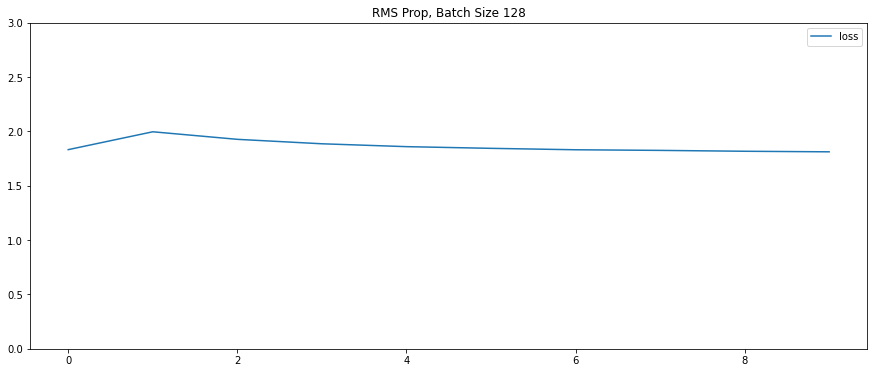

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6))

for k,v in history.history.items():
    plt.plot(history.history[k], label=k)
plt.ylim(0, 3)
plt.title('RMS Prop, Batch Size 128')
plt.legend()

### Step 6. 모델 평가하기
---
단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

> Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.
> decode sentence를 구성할 때 고민해보세요!!

고민하다 풀리지 않을 경우에는 하단 내용 참고해주세요.

루브릭  
아래의 기준을 바탕으로 프로젝트를 평가합니다.  
평가문항	상세기준

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.  
구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.  

2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.  
seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.

3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.  
테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.


### 고찰
1. 단어 단위 임베딩에 따른 인풋 벡터의 변화에 대한 이해가 좀 어려웠다.
2. 중복되는 문장이 있어 이를 제거 후 성능이 좋아짐을 확인했다. 전처리와 데이타를 살펴보는 과정은 늘 중요함을 알 수 있었다.
3. 모델 학습에 소요되는 시간이 많아 다양한 실험을 해보지 못한 점이 아쉬웠다.
4. 모델 학습 시도 시 오류가 발생하여 디버깅에 많은 시간을 소모했는데, 원인은 로스 함수의 선택에 문제가 있었다. 항상 기본에 충실해야 한다는 점을 깨달았다.
